In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier

from skimage import io
from skimage.transform import resize
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from sklearn.model_selection import cross_val_predict, StratifiedKFold

import pickle
from os import listdir
from os.path import isfile, join
from matplotlib.colors import ListedColormap

from keras.datasets import fashion_mnist

import os
from skimage import io, color, img_as_ubyte, img_as_float
from skimage.measure import shannon_entropy
from minisom import MiniSom


from skimage.feature import graycomatrix
from skimage.measure import shannon_entropy
from skimage import color
from skimage.feature import greycomatrix
from skimage import img_as_ubyte
from skimage.filters import gabor
from skimage import exposure
from skimage.measure import shannon_entropy
import numpy as np

# Fashion_mist database

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.835812836662402


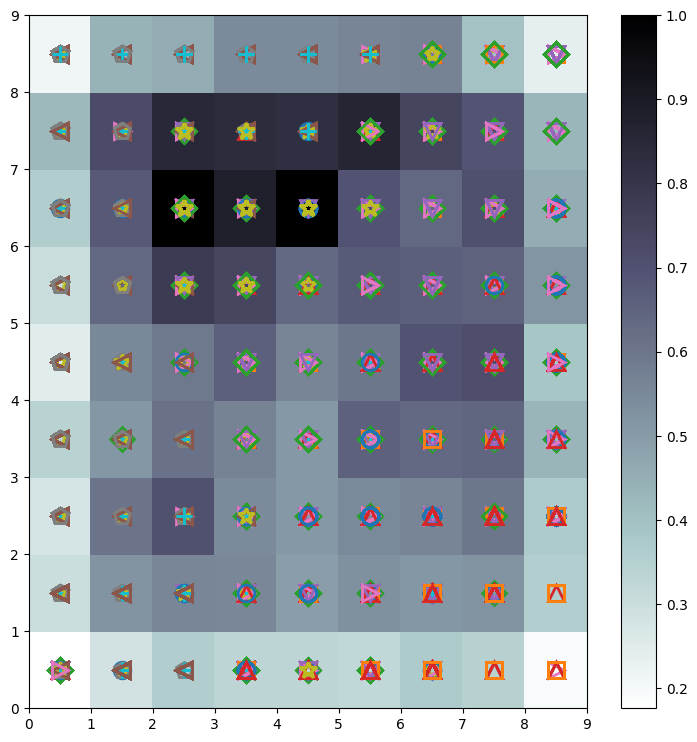

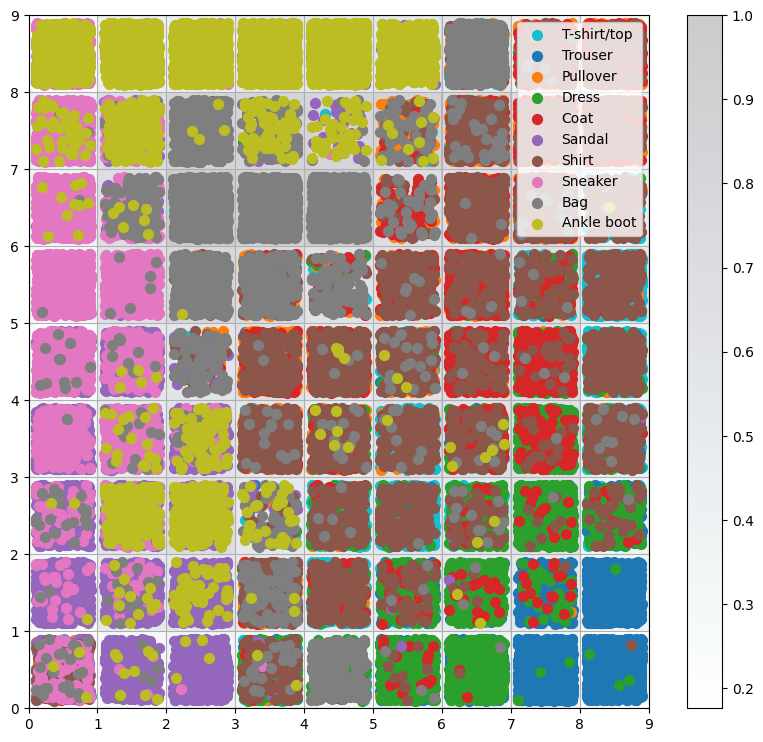

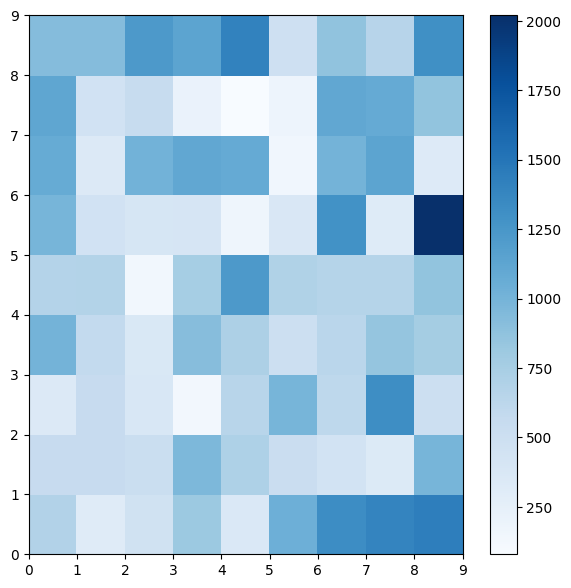

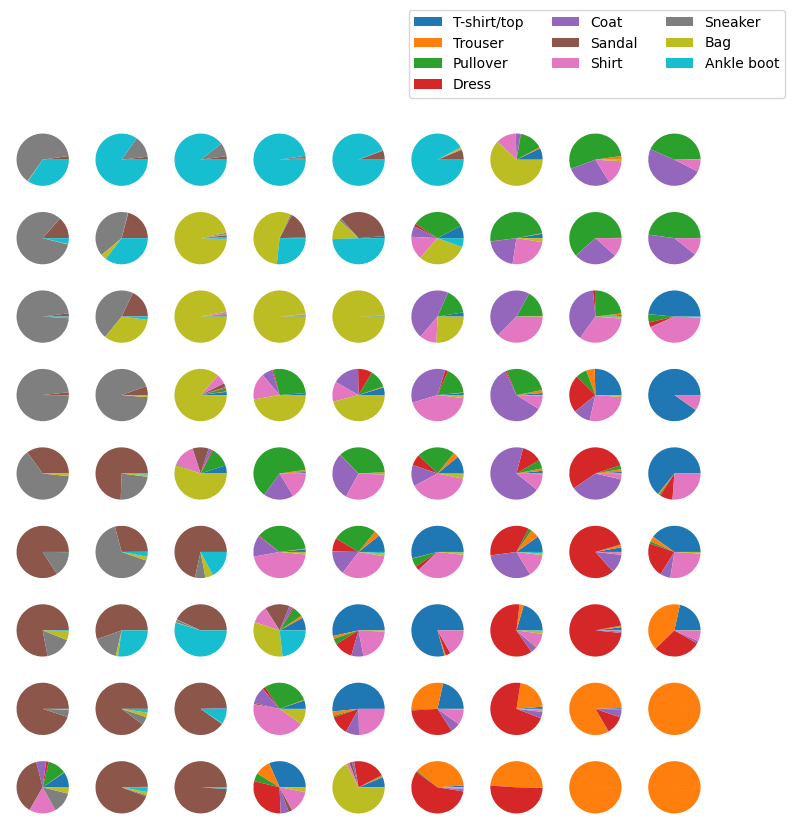

In [ ]:
import pandas as pd
import numpy as np
from minisom import MiniSom
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# Cargar datos de Fashion-MNIST
(x_train, y_train), (_, _) = fashion_mnist.load_data()

label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Redimensionar y normalizar datos
data = x_train.reshape(x_train.shape[0], -1) / 255.0

n_neurons = 9
m_neurons = 9
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')

som.pca_weights_init(data)
som.train(data, 1000, verbose=True)  # entrenamiento aleatorio

# Visualización de mapas autoorganizados
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # Traza el mapa de distancia como fondo
plt.colorbar()

# Visualización de patrones en Fashion-MNIST en el mapa autoorganizado
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for cnt, xx in enumerate(data):
    w = som.winner(xx)  # Obtener el ganador
    # Coloca un marcador en la posición ganadora para la muestra xx
    plt.plot(w[0]+.5, w[1]+.5, markers[y_train[cnt]], markerfacecolor='None',
             markeredgecolor=colors[y_train[cnt]], markersize=12, markeredgewidth=2)

plt.show()

w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(y_train):
    idx_target = y_train==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(figsize=(7, 7))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues')
plt.colorbar()
plt.show()

import matplotlib.gridspec as gridspec

labels_map = som.labels_map(data, [label_names[t] for t in y_train])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.show()

# Imagines Satelitales

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#------------------------------------------------------------------------------------------------------------------
#Load image files
#------------------------------------------------------------------------------------------------------------------
scale = 8
img_width = int(1920/scale)
img_height = int(1080/scale)

paths = ['/content/drive/MyDrive/Semestre 5/Redes Neuronales/Biomas/Agua/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Biomas/Bosque/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Biomas/Ciudad/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Biomas/Cultivo/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Biomas/Desierto/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Biomas/Montaña/']

images = []
labels = []
for label, p in enumerate(paths):
    files = [f for f in listdir(p) if isfile(join(p, f))]
    for f in files:
        print("Loading:", p + f)
        labels.append(label)
        rgb = io.imread(p + f)
        rgb_resized = resize(rgb, (img_height, img_width), anti_aliasing=True)
        images.append(rgb_resized)

n_img = len(images)
labels = np.array(labels)

#------------------------------------------------------------------------------------------------------------------
#   Color histograms
#------------------------------------------------------------------------------------------------------------------
nbins = 16
hist_descriptor = []
for rgb_resized in images:
  rh = np.histogram(rgb_resized[:,:,0].flatten(), nbins, density = True)
  gh = np.histogram(rgb_resized[:,:,1].flatten(), nbins, density = True)
  bh = np.histogram(rgb_resized[:,:,2].flatten(), nbins, density = True)
  hist_descriptor.append(np.concatenate((rh[0], gh[0], bh[0])))

#------------------------------------------------------------------------------------------------------------------
#   Texture descriptors
#------------------------------------------------------------------------------------------------------------------
texture_desc = []

for rgb_resized in images:
  gray_resized = img_as_ubyte(rgb2gray(rgb_resized))
  glcm = graycomatrix(gray_resized, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4])

  texture_desc.append([graycoprops(glcm, 'dissimilarity')[0, 0], graycoprops(glcm, 'homogeneity')[0, 0], graycoprops(glcm, 'energy')[0, 0], graycoprops(glcm, 'correlation')[0, 0]])


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.823524153374551


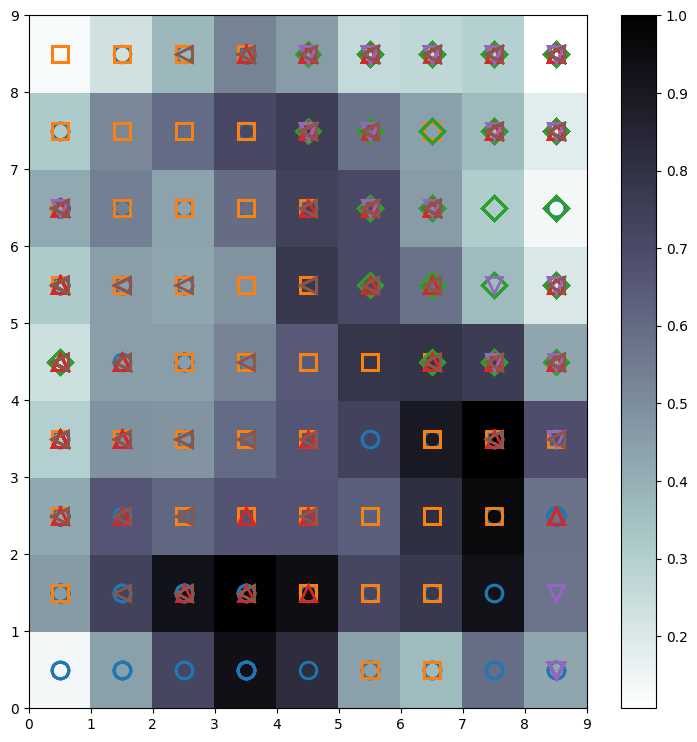

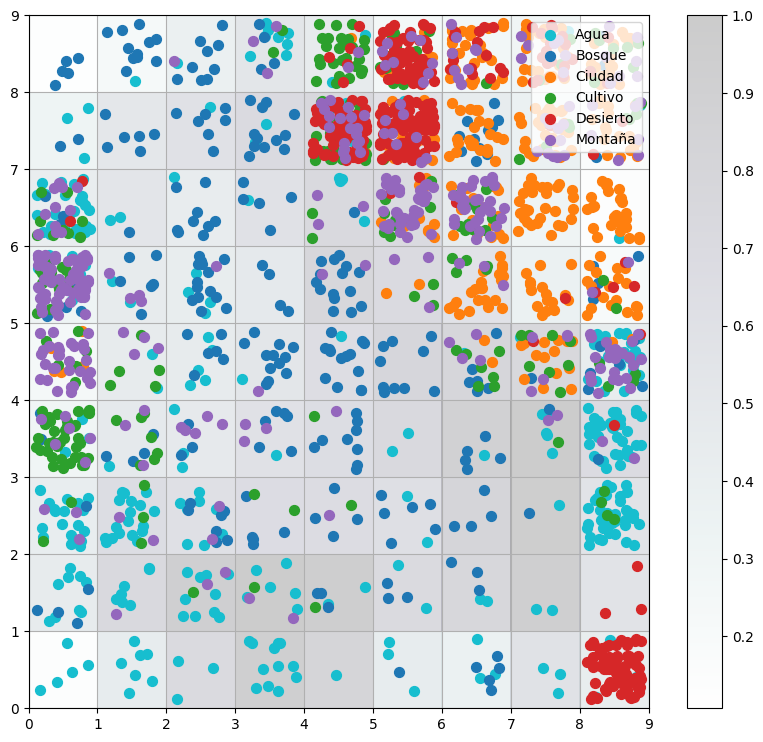

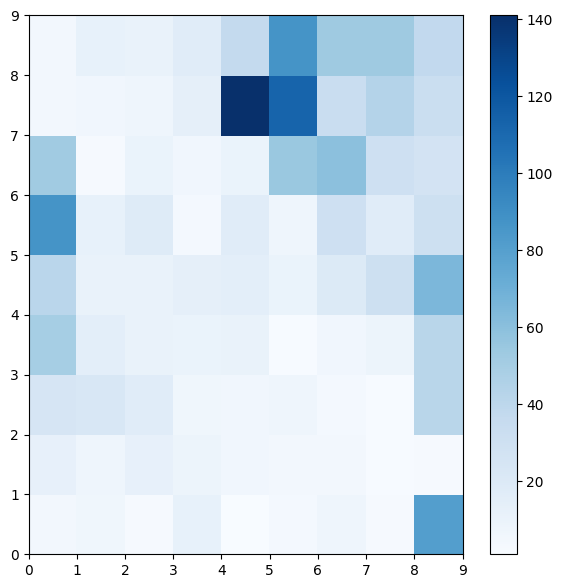

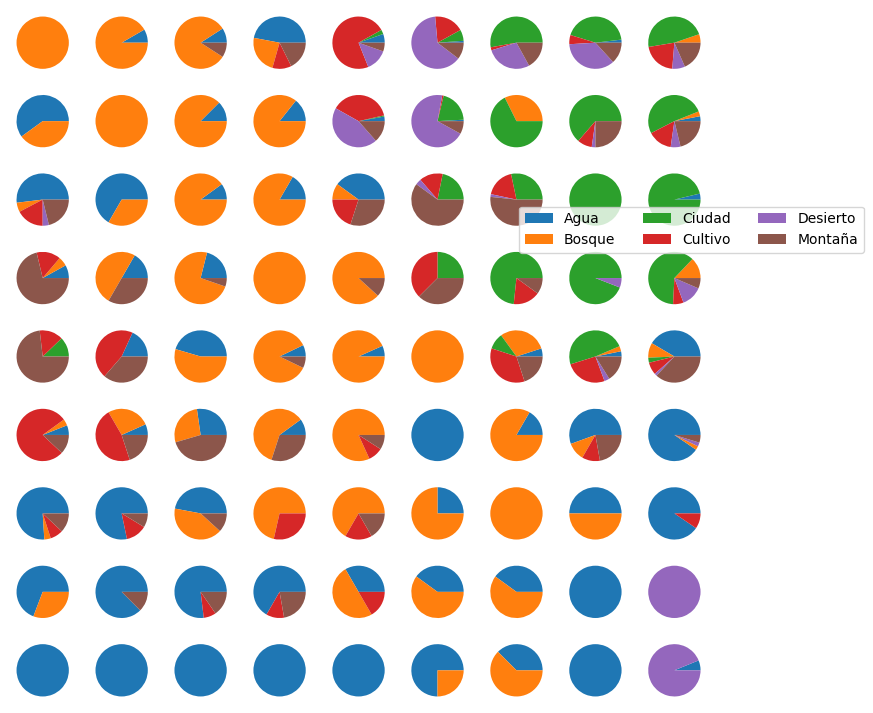

In [ ]:
label_names = {
    0: 'Agua',
    1: 'Bosque',
    2: 'Ciudad',
    3: 'Cultivo',
    4: 'Desierto',
    5: 'Montaña',
}

# Normalizar los datos
x = np.concatenate((texture_desc, hist_descriptor), axis=1)
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

# Crear e inicializar el SOM
n_neurons = 9
m_neurons = 9
som = MiniSom(n_neurons, m_neurons, x.shape[1], sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')

som.pca_weights_init(x)
som.train(x, 1000, verbose=True)  # entrenamiento aleatorio

# Visualización de mapas autoorganizados
plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # trazar el mapa de distancia como fondo
plt.colorbar()

# Visualización de patrones en el mapa autoorganizado
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for cnt, xx in enumerate(x):
    w = som.winner(xx)  # obtener el ganador
    plt.plot(w[0]+.5, w[1]+.5, markers[labels[cnt]], markerfacecolor='None',
             markeredgecolor=colors[labels[cnt]], markersize=12, markeredgewidth=2)

plt.show()

w_x, w_y = zip(*[som.winner(d) for d in x])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(labels):
    idx_target = labels ==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(figsize=(7, 7))
frequencies = som.activation_response(x)
plt.pcolor(frequencies.T, cmap='Blues')
plt.colorbar()
plt.show()

import matplotlib.gridspec as gridspec

labels_map = som.labels_map(x, [label_names[t] for t in labels])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.show()

# Imagenes de objetos

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#Load image files
#------------------------------------------------------------------------------------------------------------------
scale = 8
img_width = int(1920/scale)
img_height = int(1080/scale)

paths = ['/content/drive/MyDrive/Semestre 5/Redes Neuronales/Imágenes SP/Celular/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Imágenes SP/Hats/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Imágenes SP/Lapiz/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Imágenes SP/Libro/',
         '/content/drive/MyDrive/Semestre 5/Redes Neuronales/Imágenes SP/Shoes/']

'''paths = ['/content/drive/MyDrive/Imágenes SP/Celular/',
         '/content/drive/MyDrive/Imágenes SP/Hats/',
         '/content/drive/MyDrive/Imágenes SP/Lapiz/',
         '/content/drive/MyDrive/Imágenes SP/Libro/',
         '/content/drive/MyDrive/Imágenes SP/Shoes/']'''

images = []
labels = []
for label, p in enumerate(paths):
    files = [f for f in listdir(p) if isfile(join(p, f))]
    for f in files:
        print("Loading:", p + f)
        labels.append(label)
        rgb = io.imread(p + f)
        rgb_resized = resize(rgb, (img_height, img_width), anti_aliasing=True)
        images.append(rgb_resized)


n_img = len(images)
labels = np.array(labels)

#------------------------------------------------------------------------------------------------------------------
#   Color histograms
#------------------------------------------------------------------------------------------------------------------
nbins = 16
hist_descriptor = []
for rgb_resized in images:
  rh = np.histogram(rgb_resized[:,:,0].flatten(), nbins, density = True)
  gh = np.histogram(rgb_resized[:,:,1].flatten(), nbins, density = True)
  bh = np.histogram(rgb_resized[:,:,2].flatten(), nbins, density = True)
  hist_descriptor.append(np.concatenate((rh[0], gh[0], bh[0])))

#------------------------------------------------------------------------------------------------------------------
#   Texture descriptors
#------------------------------------------------------------------------------------------------------------------
texture_desc = []

for rgb_resized in images:
  gray_resized = img_as_ubyte(rgb2gray(rgb_resized))
  glcm = graycomatrix(gray_resized, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4])

  texture_desc.append([graycoprops(glcm, 'dissimilarity')[0, 0], graycoprops(glcm, 'homogeneity')[0, 0], graycoprops(glcm, 'energy')[0, 0], graycoprops(glcm, 'correlation')[0, 0]])

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5.019970004274514


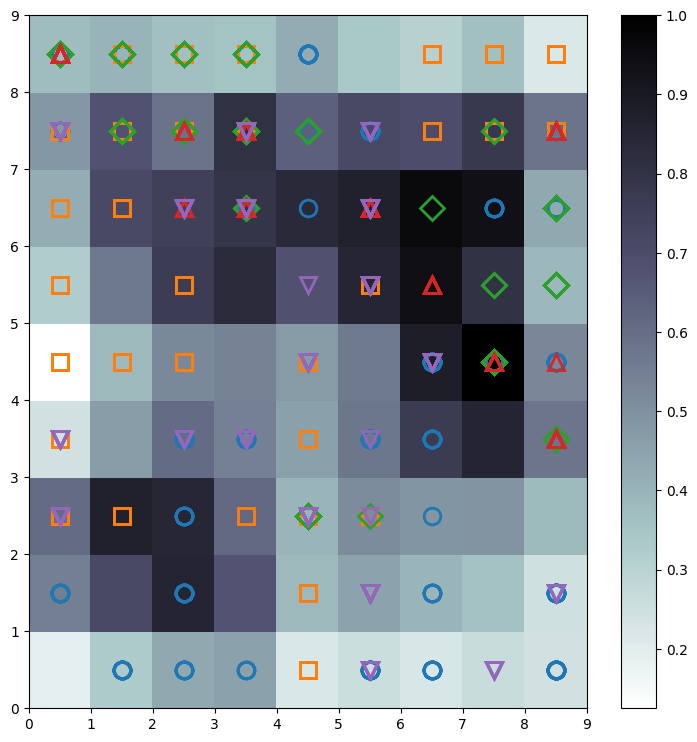

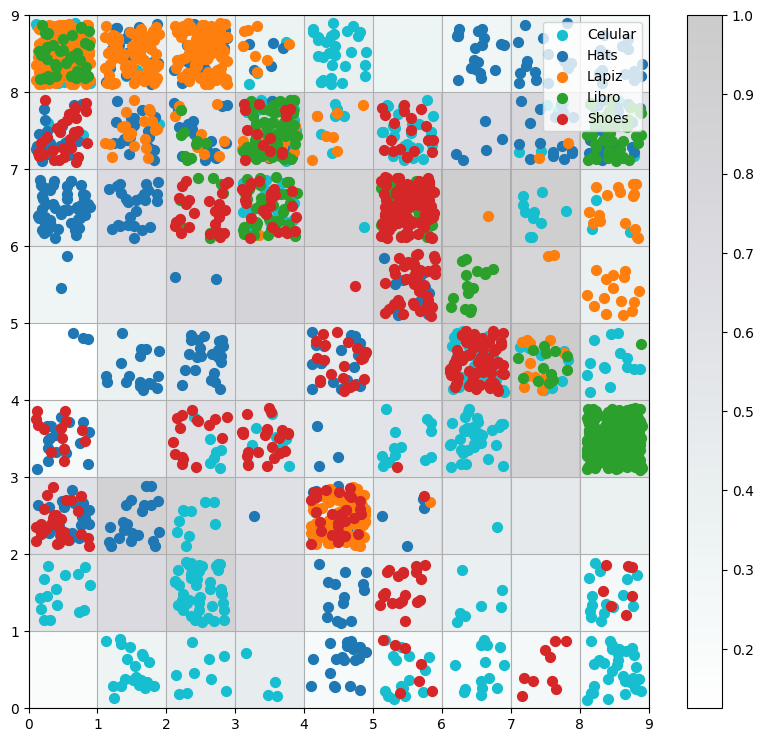

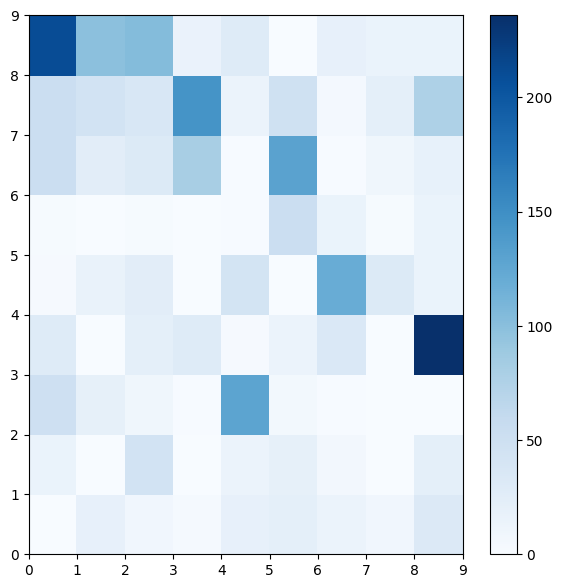

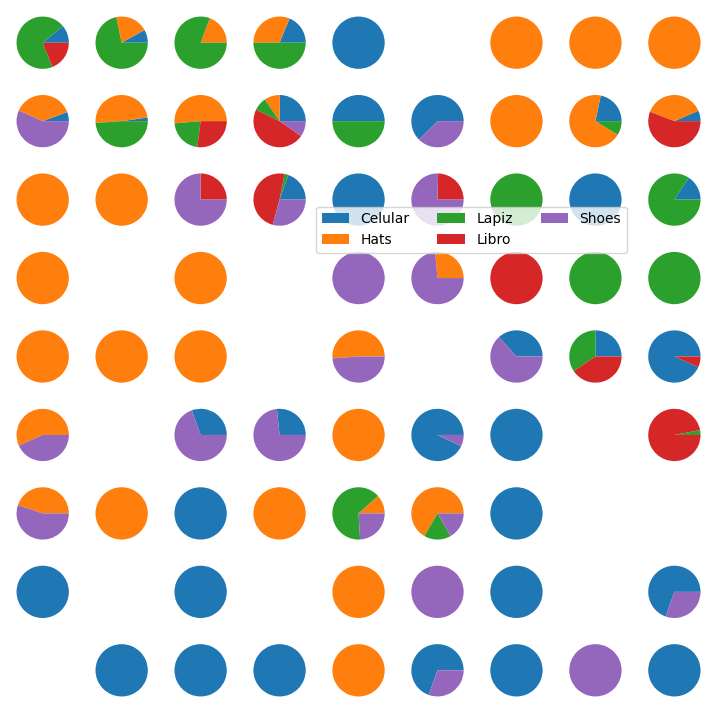

In [ ]:
label_names = {
    0: 'Celular',
    1: 'Hats',
    2: 'Lapiz',
    3: 'Libro',
    4: 'Shoes',
}

# Normalizar los datos
x = np.concatenate((texture_desc, hist_descriptor), axis=1)
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

# Crear e inicializar el SOM
n_neurons = 9
m_neurons = 9
som = MiniSom(n_neurons, m_neurons, x.shape[1], sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')

som.pca_weights_init(x)
som.train(x, 1000, verbose=True)  # entrenamiento aleatorio

# Visualización de mapas autoorganizados
plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # trazar el mapa de distancia como fondo
plt.colorbar()

# Visualización de patrones en el mapa autoorganizado
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for cnt, xx in enumerate(x):
    w = som.winner(xx)  # obtener el ganador
    plt.plot(w[0]+.5, w[1]+.5, markers[labels[cnt]], markerfacecolor='None',
             markeredgecolor=colors[labels[cnt]], markersize=12, markeredgewidth=2)

plt.show()

w_x, w_y = zip(*[som.winner(d) for d in x])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(labels):
    idx_target = labels ==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(figsize=(7, 7))
frequencies = som.activation_response(x)
plt.pcolor(frequencies.T, cmap='Blues')
plt.colorbar()
plt.show()

import matplotlib.gridspec as gridspec

labels_map = som.labels_map(x, [label_names[t] for t in labels])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.show()